# 1 Download dataset, plot dataset, and preprocess them

**1.1 download CIFAR10 dataset and extract it**


In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 100MB/s] 


**1.2 visualize 10 images from each class of dataset and plot them in a figure**

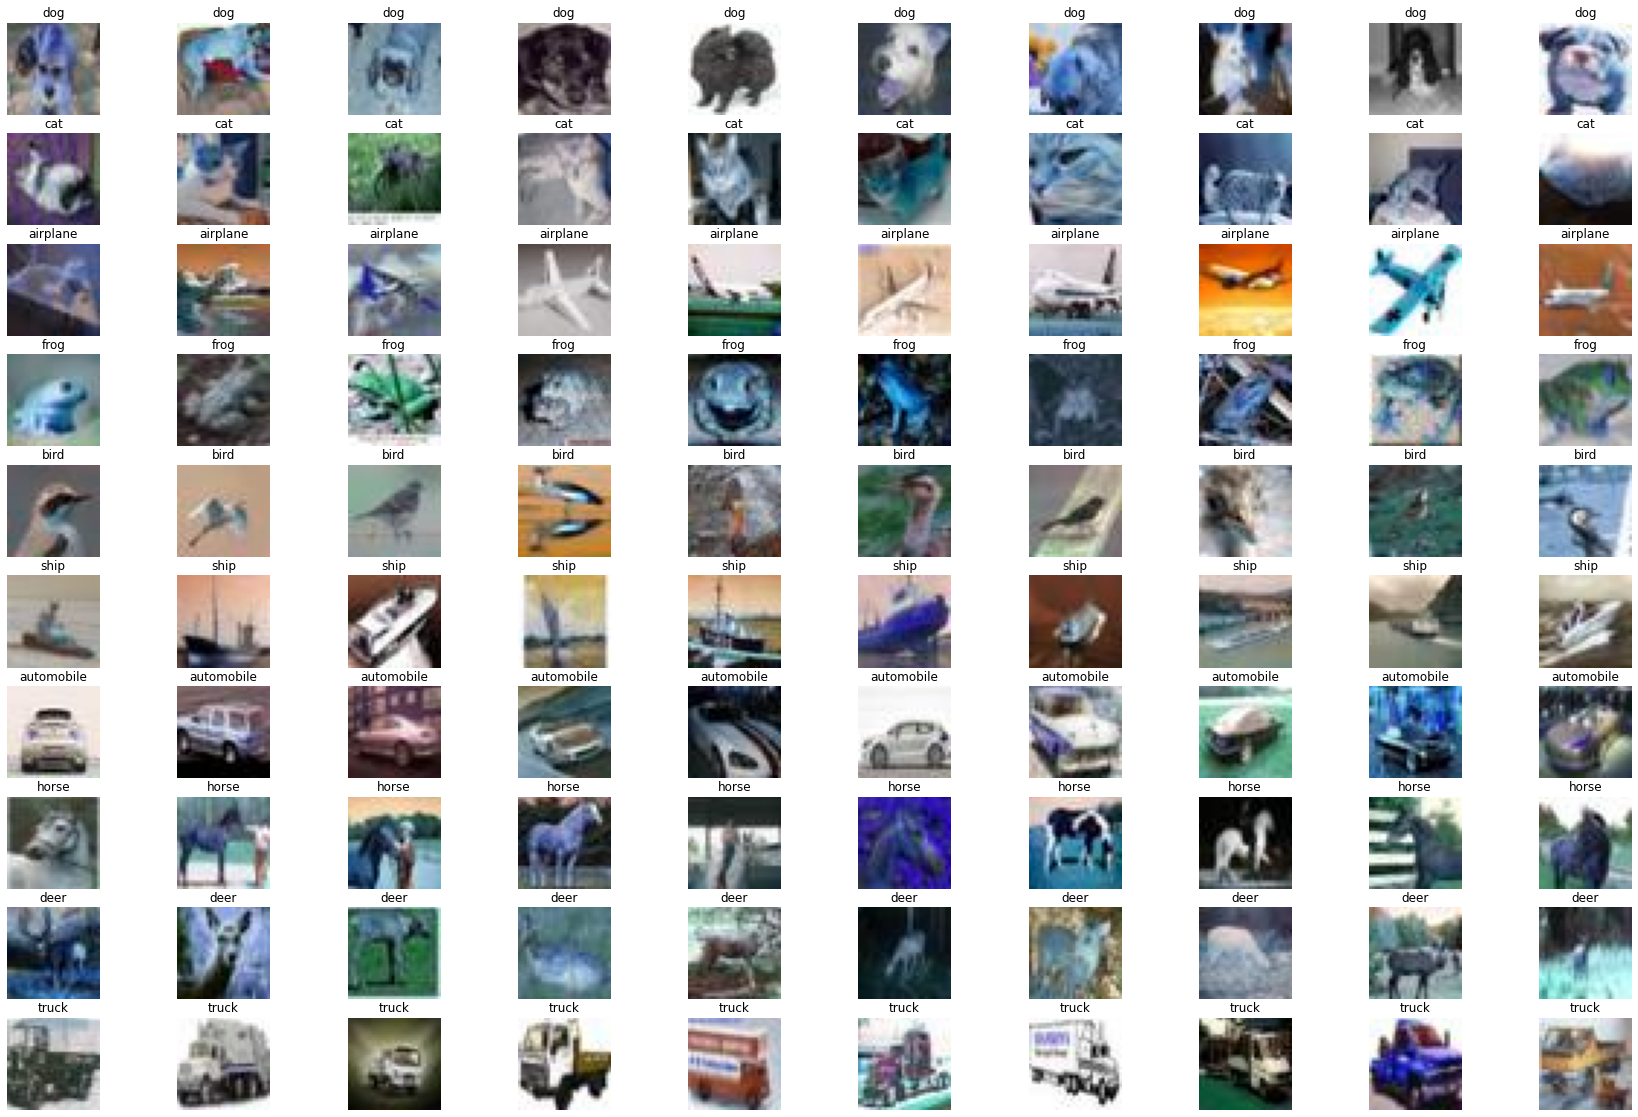

In [2]:
import cv2 # openCV library to read images as matrix
from matplotlib import pyplot as plt # for plotting images
import os, random # to find all files/directories and choose one of them randomly

# a figure for plotting 10 * 10 images
fig = plt.figure(figsize=(30, 20))
rows, columns = 10, 10

# choose 10 images from each directory randomly and also show them in the figure
j = 1
for dir in os.listdir('CIFAR10/train'):
  for i in range(10):
    fig.add_subplot(rows, columns, j)
    img = cv2.imread('CIFAR10/train/'+ dir + "/" + random.choice(os.listdir('CIFAR10/train/'+dir)))
    plt.imshow(img)
    plt.axis('off')
    plt.title(dir)
    j += 1

**1.3 preprocess train images and test images**

In [3]:
import numpy as np # to work with lists as matrices

# classes we want to preprocess from these two datasets
classes = ['cat', 'bird', 'automobile', 'airplane']

# preprocess train images
train_img = []
train_label = np.array([0, 0, 0, 0])
for dir in classes:
  class_index = classes.index(dir)
  for img in os.listdir('CIFAR10/train/' + dir):
    # imread convert each image into a matrix
    img = cv2.imread('CIFAR10/train/'+ dir + "/" + img)
    train_img.append(img)
    # label of each image is a 4*1 vector (because we have four output neurons)
    label_vector = np.zeros((1, len(classes)))
    label_vector[0, class_index] = 1
    train_label = np.vstack((train_label, label_vector))

train_img = np.array(train_img) # train images as matrix
train_label = np.delete(train_label, 0, 0) # train image labels as one-hot matrix

# preprocess test images (like train images, but with a different dataset)
test_img = []
test_label = np.array([0, 0, 0, 0])
for dir in classes:
  class_index = classes.index(dir)
  for img in os.listdir('CIFAR10/test/' + dir):
    # imread convert each image into a matrix
    img = cv2.imread('CIFAR10/test/'+ dir + "/" + img)
    test_img.append(img)
    # label of each image is a 4*1 vector (because we have four output neurons)
    label_vector = np.zeros((1, len(classes)))
    label_vector[0, class_index] = 1
    test_label = np.vstack((test_label, label_vector))

test_img = np.array(test_img) # test images as matrix
test_label = np.delete(test_label, 0, 0) # test image lables as one-hot matrix

# check for the shape of matrices we created
print(train_img.shape, train_label.shape) 
print(test_img.shape, test_label.shape)

(20000, 32, 32, 3) (20000, 4)
(4000, 32, 32, 3) (4000, 4)


**1.3.1 convert images from rgb to gray scale**

In [4]:
# a function to convert rgb to gray images
def rgb2gray(rgb):
  # convert the 3 dimensional matrix (rgb) into 1 dimensional matrix (gray)
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

# convert our dataset into gray images (to reduce the complexity of computations)
gray_train_img = rgb2gray(train_img)
gray_test_img = rgb2gray(test_img)
# check for correctness of the conversion
print(gray_train_img.shape, gray_test_img.shape)

(20000, 32, 32) (4000, 32, 32)


**1.3.2 normalize dataset**

In [5]:
# a function to make image matrices normal (by division into 255)
def normalize(images):
  return images / 255

# normalize dataset to decrease learning time 
gray_train_img = normalize(gray_train_img)
gray_test_img = normalize(gray_test_img)

**1.3.3 flat dataset**

In [6]:
# a function to make images flat (as a vector of 1*1024)
def flat(images):
  return images.reshape(-1, 1024)

# make dataset flat
gray_train_img = flat(gray_train_img)
gray_test_img = flat(gray_test_img)

**1.3.4 shuffle dataset**

In [7]:
# a function to shuffle dataset
def shuffle_dataset(images, label):
  ''' note that we must shuffle images and their labels in the same way,
   because they are correspond together (thus we need to combine them first and decompose them lastly)'''
  combine =  np.hstack((images, label)) # combine images and labels
  np.random.shuffle(combine)
  return (np.hsplit(combine, np.array([1024, ])))[0], (np.hsplit(combine, np.array([1024, ])))[1] # decompose images and labels

# shuffle our dataset
gray_train_img, train_label = shuffle_dataset(gray_train_img, train_label)
gray_test_img, test_label = shuffle_dataset(gray_test_img, test_label)

# 2 FeedForward (compute output)

**2.1 sigmoid activation function**

In [8]:
# sigmoid activation function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

**2.2 initialize weights, biases, and number of layers**

In [9]:
# number of neurons in each layer
L1, L2, L3, L4 = 1024, 16, 16, 4

# initialize weights with random normal matrices
def initialize_weights():
  W1 = np.random.normal(size=(L2, L1))
  W2 = np.random.normal(size=(L3, L2))
  W3 = np.random.normal(size=(L4, L3))
  return W1, W2, W3

# initialize biases to zero vectors
def initialize_biases():
  b1 = np.zeros((L2, 1))
  b2 = np.zeros((L3, 1))
  b3 = np.zeros((L4, 1))
  return b1, b2, b3

**2.3 compute the output for a small range of the train set**

In [10]:
# pick 200 data from the train set with their labels
X = (np.vsplit(gray_train_img, np.array([200, ])))[0] # image
Y_star = (np.vsplit(train_label, np.array([200, ])))[0] # label

# initialize weights and biases
W1, W2, W3 = initialize_weights()
b1, b2, b3 = initialize_biases()

# compute output in the feedforward phase
a1 = sigmoid((np.dot(W1, X.T) + b1)) # activation nodes of the second layer
a2 = sigmoid((np.dot(W2, a1) + b2)) # activation nodes of the third layer
a3 = sigmoid((np.dot(W3, a2) + b3)) # activation nodes of the fourth layer
a3 = a3.T

# Y is the predicted matrix of inputs
Y = np.empty_like(a3)
j = 0
for i in np.argmax(a3, axis=1):
  Y_vector = np.zeros((1, len(classes)))
  Y_vector[0, i] = 1
  Y[j] = Y_vector
  j += 1

# find the number of correct predictions by our neural network
j = 0 # number of correct predictions
for i in (Y_star - Y):
  if (i == np.array([0, 0, 0, 0])).all():
    j += 1

# accuracy of our model (it may be near 25 %)
accuracy = (j / 200) * 100
print("accuracy = ", accuracy)

accuracy =  25.0


# 3 Backpropagation

**3.1 cost function**

In [11]:
# sum squared error function (SSE) is our cost function
def comput_cost(Y_star, a3):
  return np.sum(np.power(Y_star - a3, 2))

**3.2 stochastic gradient descent (train our model)** </br>
here we want to train our model with a small range of datasets we picked in the feedforward phase. </br>
bellow algorithm is the stochastic gradient descent algorithm for training our model. in this part of the implementation, we must compute gradients by using "for" (which means not to use vectorization). </br>


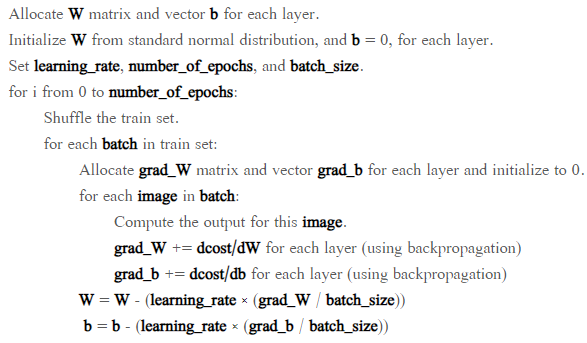

below are the gradients of weights and biases:

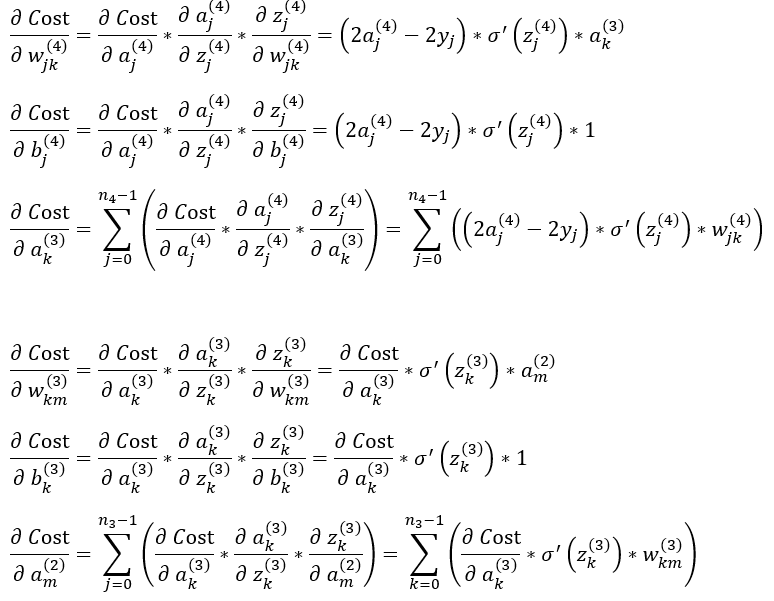

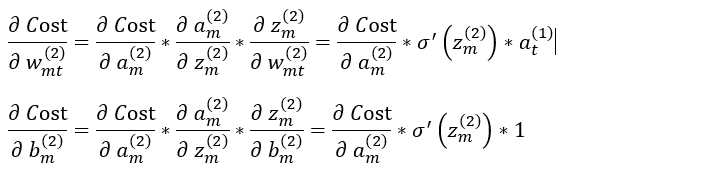

**3.2.1 non-vectorized version of gradient descent for learning**

In [12]:
from numpy.lib.shape_base import vsplit # used for batch extraction from our dataset matrix
import datetime, time # used for computing time of learning

start_time = datetime.datetime.now() # time of start learning

# allocate and initialize W matrix and vector b for each layer
W1, W2, W3 = initialize_weights()
b1, b2, b3 = initialize_biases()

# set hyperparameters (learning_rate, number_of_epochs, and batch_size)
batch_size = 16
learning_rate = 0.3
number_of_epochs = 10

'''note: we are working on a small range of datasets witch extracted 
in the previous part (X as input of NN and Y_star as output of NN)'''

# find the number of batches based on the number of data in the dataset
X_no_rows = X.shape[0]
batch_no = int(X_no_rows / batch_size)

# a list to store costs for each epoch to check that learning is doing correctly
epoch_costs_mini = []

# loop over the number of epochs
for i in range(number_of_epochs):
  X, Y_star = shuffle_dataset(X, Y_star) # shuffle the train set
  for j in range(batch_no): # loop over the batches in each epoch
    # allocate grad_W matrix and vector grad_b for each layer and initialize to 0
    grad_W3 = np.zeros_like(W3)
    grad_b3 = np.zeros_like(b3)
    grad_W2 = np.zeros_like(W2)
    grad_b2 = np.zeros_like(b2)
    grad_W1 = np.zeros_like(W1)
    grad_b1 = np.zeros_like(b1)

    # extract images of this batch
    batch_X = np.vsplit(X, np.array([16*j, 16*(j+1)]))[1]
    batch_Y_star = np.vsplit(Y_star, np.array([16*j, 16*(j+1)]))[1]
    
    # loop over images of this batch
    for k in range(np.shape(batch_X)[0]):
      # extract current image of batch
      image_X = batch_X[k].reshape(1, 1024)
      image_Y_star = batch_Y_star[k].reshape(4, 1)

      # compute the output for this image.
      a1 = sigmoid((np.dot(W1, image_X.T) + b1))
      a2 = sigmoid((np.dot(W2, a1) + b2))
      a3 = sigmoid((np.dot(W3, a2) + b3))

      # compute gradients for each layer
      ''' vectorized implementation ''' 
      # grad_W3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3))) @ (a2.T)    # d_cost/d_W3
      # grad_b3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_b3

      # grad_a2 = (W3.T) @ (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_a2
      # grad_W2 += (grad_a2 * (a2 * (1 - a2))) @ (a1.T)    # d_cost/d_W2
      # grad_b2 += (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_b2
        
      # grad_a1 = (W2.T) @ (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_a1
      # grad_W1 += (grad_a1 * (a1 * (1 - a1))) @ (image_X) # d_cost/d_W1
      # grad_b1 += (grad_a1 * (a1 * (1 - a1)))    # d_cost/d_b1
      
      ''' implementation with "for" '''
      # d_cost/d_W3
      for j in range(L4):
        for k in range(L3):
          grad_W3[j][k] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j])) * a2[k]
      # d_cost/d_b3
      for j in range(L4):
        grad_b3[j] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j]))
      # d_cost/d_a2
      grad_a2 = np.zeros_like(a2)
      for k in range(L3):
        for j in range(L4):
          grad_a2[k] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j])) * W3[j][k]
      # d_cost/d_W2
      for k in range(L3):
        for m in range(L2):
          grad_W2[k][m] += grad_a2[k] * (a2[k] * (1 - a2[k])) * a1[m]
      # d_cost/d_b2
      for k in range(L3):
        grad_b2[k] += grad_a2[k] * (a2[k] * (1 - a2[k]))
      # d_cost/d_a1
      grad_a1 = np.zeros_like(a1)
      for m in range(L2):
        for k in range(L3):
          grad_a1[m] += grad_a2[k] * (a2[k] * (1 - a2[k])) * W2[k][m]
      # d_cost/d_W1
      for m in range(L2):
        for t in range(L1):
          grad_W1[m][t] += grad_a1[m] * (a1[m] * (1 - a1[m])) * image_X.T[t]
      # d_cost/d_b1
      for m in range(L2):
        grad_b1[m] += grad_a1[m] * (a1[m] * (1 - a1[m]))

    # move to local minimum
    W3 -= (learning_rate * (grad_W3/batch_size))
    W2 -= (learning_rate * (grad_W2/batch_size))
    W1 -= (learning_rate * (grad_W1/batch_size))

    b3 -= (learning_rate * (grad_b3/batch_size))
    b2 -= (learning_rate * (grad_b2/batch_size))
    b1 -= (learning_rate * (grad_b1/batch_size))
  
  # compute output for each epoch
  a1 = sigmoid((np.dot(W1, X.T) + b1))
  a2 = sigmoid((np.dot(W2, a1) + b2))
  a3 = sigmoid((np.dot(W3, a2) + b3))
  a3 = a3.T
  
  # compute cost of each epoch
  epoch_cost = comput_cost(Y_star, a3)
  epoch_costs_mini.append(epoch_cost)


end_time = datetime.datetime.now() # time of end learning

# compute learning time
learning_time = end_time - start_time
print("total time for learning: ", learning_time)

total time for learning:  0:05:06.483769


In [13]:
# compute accuracy of model
a1 = sigmoid((np.dot(W1, X.T) + b1))
a2 = sigmoid((np.dot(W2, a1) + b2))
a3 = sigmoid((np.dot(W3, a2) + b3))
a3 = a3.T

# Y is the predicted matrix of inputs
Y = np.empty_like(a3)
j = 0
for i in np.argmax(a3, axis=1):
  Y_vector = np.zeros((1, len(classes)))
  Y_vector[0, i] = 1
  Y[j] = Y_vector
  j += 1

# find the number of correct predictions by our neural network
j = 0 # number of correct predictions
for i in (Y_star - Y):
  if (i == np.array([0, 0, 0, 0])).all():
    j += 1

# accuracy of our model (it may be near 30 %)
accuracy = (j / 200) * 100
print("accuracy = ", accuracy)

accuracy =  35.0


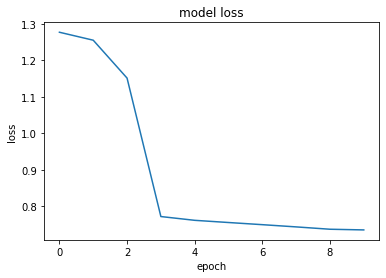

In [14]:
# plot model loss (loss of each epoch)
import matplotlib.pyplot as plt
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.array(epoch_costs_mini)/X_no_rows)
plt.show()

**3.2.2 vectorized version of gradient descent for learning**</br>
the code will run 10 times and the average accuracy will be printed

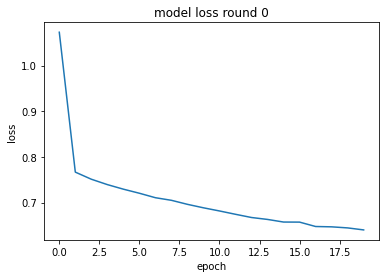

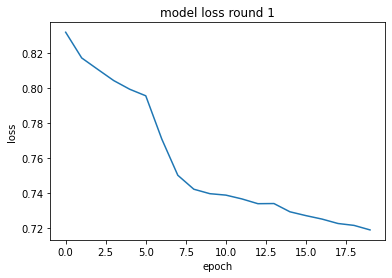

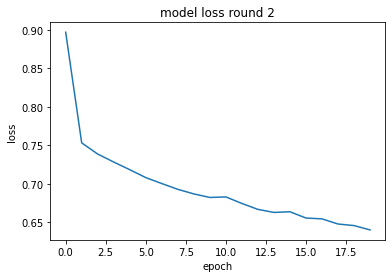

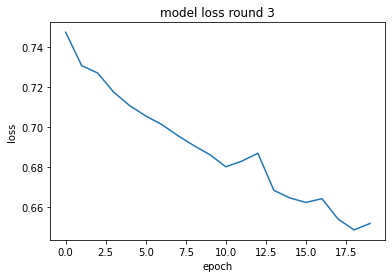

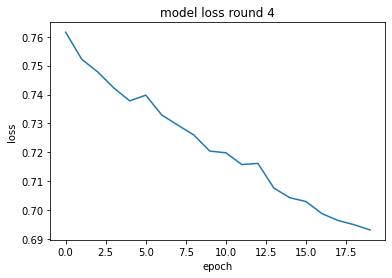

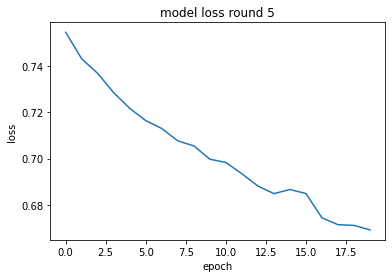

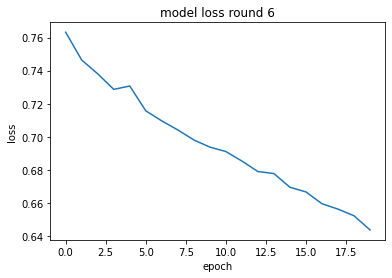

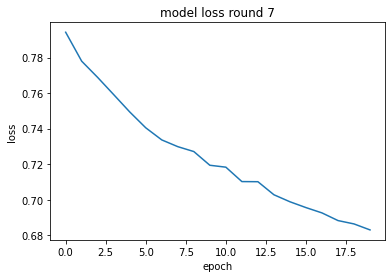

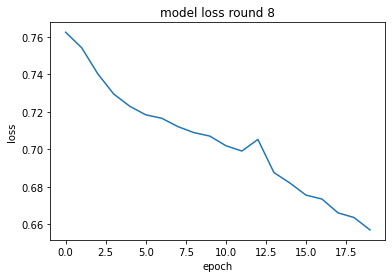

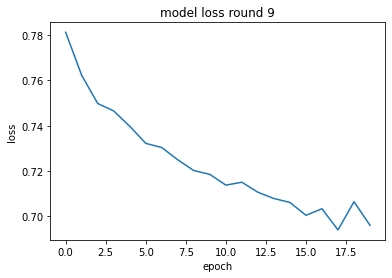

total time for learning:  0:00:13.140820
average of accuracy is:  45.55


In [15]:
from numpy.lib.shape_base import vsplit # used for batch extraction from our dataset matrix
import datetime, time # used for computing time of learning
import matplotlib.pyplot as plt

start_time = datetime.datetime.now() # time of start learning

avg_accuracy = 0
for r in range(10):
  # allocate and initialize W matrix and vector b for each layer
  W1, W2, W3 = initialize_weights()
  b1, b2, b3 = initialize_biases()

  # set hyperparameters (learning_rate, number_of_epochs, and batch_size)
  batch_size = 16
  learning_rate = 0.3
  number_of_epochs = 20

  '''note: we are working on a small range of datasets witch extracted 
  in the previous part (X as input of NN and Y_star as output of NN)'''

  # find the number of batches based on the number of data in the dataset
  X_no_rows = X.shape[0]
  batch_no = int(X_no_rows / batch_size)

  # a list to store costs for each epoch to check that learning is doing correctly
  epoch_costs_mini = []

  # loop over the number of epochs
  for i in range(number_of_epochs):
    X, Y_star = shuffle_dataset(X, Y_star) # shuffle the train set
    for j in range(batch_no): # loop over the batches in each epoch
      # allocate grad_W matrix and vector grad_b for each layer and initialize to 0.
      grad_W3 = np.zeros_like(W3)
      grad_b3 = np.zeros_like(b3)
      grad_W2 = np.zeros_like(W2)
      grad_b2 = np.zeros_like(b2)
      grad_W1 = np.zeros_like(W1)
      grad_b1 = np.zeros_like(b1)

      # extract images of this batch
      batch_X = np.vsplit(X, np.array([16*j, 16*(j+1)]))[1]
      batch_Y_star = np.vsplit(Y_star, np.array([16*j, 16*(j+1)]))[1]
      
      # loop over images of this batch
      for k in range(np.shape(batch_X)[0]):
        # extract current image of batch
        image_X = batch_X[k].reshape(1, 1024)
        image_Y_star = batch_Y_star[k].reshape(4, 1)

        # compute the output for this image.
        a1 = sigmoid((np.dot(W1, image_X.T) + b1))
        a2 = sigmoid((np.dot(W2, a1) + b2))
        a3 = sigmoid((np.dot(W3, a2) + b3))

        # compute gradients for each layer
        ''' vectorized implementation ''' 
        grad_W3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3))) @ (a2.T)    # d_cost/d_W3
        grad_b3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_b3

        grad_a2 = (W3.T) @ (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_a2
        grad_W2 += (grad_a2 * (a2 * (1 - a2))) @ (a1.T)    # d_cost/d_W2
        grad_b2 += (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_b2
          
        grad_a1 = (W2.T) @ (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_a1
        grad_W1 += (grad_a1 * (a1 * (1 - a1))) @ (image_X) # d_cost/d_W1
        grad_b1 += (grad_a1 * (a1 * (1 - a1)))    # d_cost/d_b1
        
        ''' implementation with "for" '''
        # # d_cost/d_W3
        # for j in range(L4):
        #   for k in range(L3):
        #     grad_W3[j][k] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j])) * a2[k]
        # # d_cost/d_b3
        # for j in range(L4):
        #   grad_b3[j] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j]))
        # # d_cost/d_a2
        # grad_a2 = np.zeros_like(a2)
        # for k in range(L3):
        #   for j in range(L4):
        #     grad_a2[k] += 2 * (a3[j] - image_Y_star[j]) * (a3[j] * (1 - a3[j])) * W3[j][k]
        # # d_cost/d_W2
        # for k in range(L3):
        #   for m in range(L2):
        #     grad_W2[k][m] += grad_a2[k] * (a2[k] * (1 - a2[k])) * a1[m]
        # # d_cost/d_b2
        # for k in range(L3):
        #   grad_b2[k] += grad_a2[k] * (a2[k] * (1 - a2[k]))
        # # d_cost/d_a1
        # grad_a1 = np.zeros_like(a1)
        # for m in range(L2):
        #   for k in range(L3):
        #     grad_a1[m] += grad_a2[k] * (a2[k] * (1 - a2[k])) * W2[k][m]
        # # d_cost/d_W1
        # for m in range(L2):
        #   for t in range(L1):
        #     grad_W1[m][t] += grad_a1[m] * (a1[m] * (1 - a1[m])) * image_X.T[t]
        # # d_cost/d_b1
        # for m in range(L2):
        #   grad_b1[m] += grad_a1[m] * (a1[m] * (1 - a1[m]))

      # move to local minimum
      W3 -= (learning_rate * (grad_W3/batch_size))
      W2 -= (learning_rate * (grad_W2/batch_size))
      W1 -= (learning_rate * (grad_W1/batch_size))

      b3 -= (learning_rate * (grad_b3/batch_size))
      b2 -= (learning_rate * (grad_b2/batch_size))
      b1 -= (learning_rate * (grad_b1/batch_size))
    
    # compute output for each epoch
    a1 = sigmoid((np.dot(W1, X.T) + b1))
    a2 = sigmoid((np.dot(W2, a1) + b2))
    a3 = sigmoid((np.dot(W3, a2) + b3))
    a3 = a3.T
    
    # compute cost of each epoch
    epoch_cost = comput_cost(Y_star, a3)
    epoch_costs_mini.append(epoch_cost)

  # plot model loss (loss of each epoch)
  title = "model loss round " + str(r)
  plt.title(title)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.plot(np.array(epoch_costs_mini)/X_no_rows)
  plt.show()

  # compute accuracy of model
  a1 = sigmoid((np.dot(W1, X.T) + b1))
  a2 = sigmoid((np.dot(W2, a1) + b2))
  a3 = sigmoid((np.dot(W3, a2) + b3))
  a3 = a3.T

  # Y is the predicted matrix of inputs
  Y = np.empty_like(a3)
  j = 0
  for i in np.argmax(a3, axis=1):
    Y_vector = np.zeros((1, len(classes)))
    Y_vector[0, i] = 1
    Y[j] = Y_vector
    j += 1

  # find the number of correct predictions by our neural network
  j = 0 # number of correct predictions
  for i in (Y_star - Y):
    if (i == np.array([0, 0, 0, 0])).all():
      j += 1

  # accuracy of our model (it may be near 30 %)
  accuracy = (j / 200) * 100
  avg_accuracy += accuracy

end_time = datetime.datetime.now() # time of end learning

# compute learning time
learning_time = end_time - start_time
avg_accuracy /= 10
print("total time for learning: ", learning_time)
print("average of accuracy is: ", avg_accuracy)

# 4 Testing our model</br>
test our model with all data in the first four classes of the train set </br>
to do this, we have matrices **gray_train_img** and **gray_test_img** and **train_label** and **test_label** from first part of implementation.



**4.1 working on train dataset**

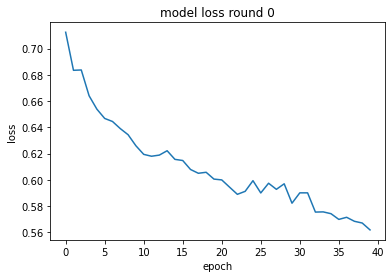

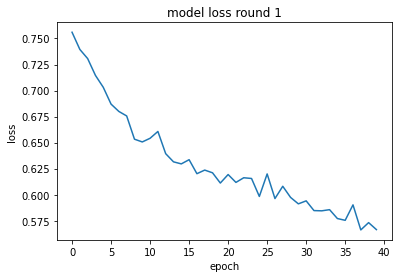

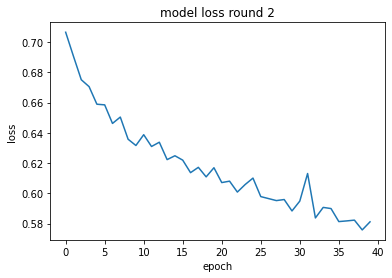

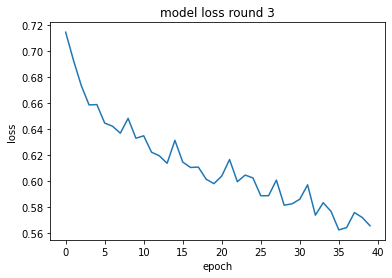

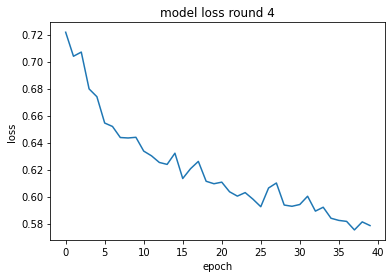

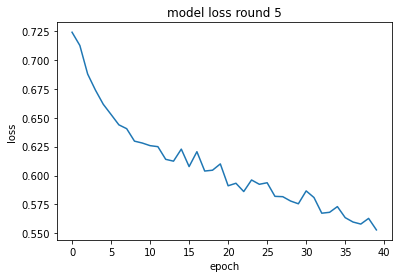

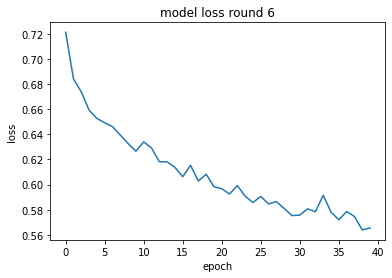

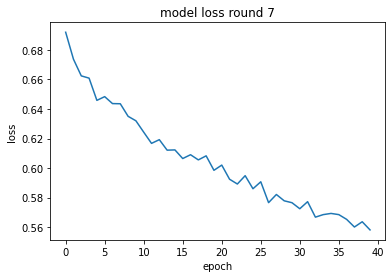

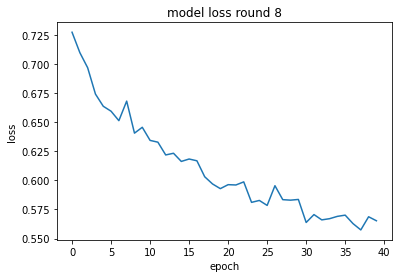

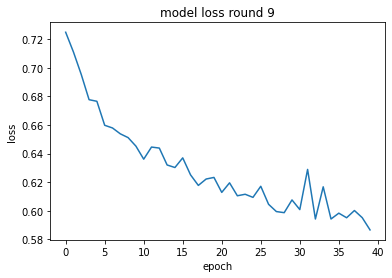

total time for learning:  0:14:42.958427
average of accuracy is:  55.888749999999995


In [16]:
from numpy.lib.shape_base import vsplit # used for batch extraction from our dataset matrix
import datetime, time # used for computing time of learning
import matplotlib.pyplot as plt

# pick 8000 data from the train set with their labels
gray_train_img_8000 = (np.vsplit(gray_train_img, np.array([8000, ])))[0] # image
train_label_8000 = (np.vsplit(train_label, np.array([8000, ])))[0] # label

start_time = datetime.datetime.now() # time of start learning

avg_accuracy = 0
for r in range(10):
  # allocate and initialize W matrix and vector b for each layer
  W1, W2, W3 = initialize_weights()
  b1, b2, b3 = initialize_biases()

  # set hyperparameters (learning_rate, number_of_epochs, and batch_size)
  batch_size = 16
  learning_rate = 0.3
  number_of_epochs = 40

  # find the number of batches based on the number of data in the dataset
  X_no_rows = gray_train_img_8000.shape[0]
  batch_no = int(X_no_rows / batch_size)

  # a list to store costs for each epoch to check that learning is doing correctly
  epoch_costs_all = []

  # loop over the number of epochs
  for i in range(number_of_epochs):
    gray_train_img_8000, train_label_8000 = shuffle_dataset(gray_train_img_8000, train_label_8000) # shuffle the train set
    for j in range(batch_no): # loop over the batches in each epoch
      # allocate grad_W matrix and vector grad_b for each layer and initialize to 0
      grad_W3 = np.zeros_like(W3)
      grad_b3 = np.zeros_like(b3)
      grad_W2 = np.zeros_like(W2)
      grad_b2 = np.zeros_like(b2)
      grad_W1 = np.zeros_like(W1)
      grad_b1 = np.zeros_like(b1)

      # extract images of this batch
      batch_X = np.vsplit(gray_train_img_8000, np.array([16*j, 16*(j+1)]))[1]
      batch_Y_star = np.vsplit(train_label_8000, np.array([16*j, 16*(j+1)]))[1]

      # loop over images of this batch
      for k in range(np.shape(batch_X)[0]):
        # extract current image of batch
        image_X = batch_X[k].reshape(1, 1024)
        image_Y_star = batch_Y_star[k].reshape(4, 1)

        # compute the output for this image.
        a1 = sigmoid((np.dot(W1, image_X.T) + b1))
        a2 = sigmoid((np.dot(W2, a1) + b2))
        a3 = sigmoid((np.dot(W3, a2) + b3))

        # compute gradients for each layer
        grad_W3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3))) @ (a2.T)    # d_cost/d_W3
        grad_b3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_b3

        grad_a2 = (W3.T) @ (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_a2
        grad_W2 += (grad_a2 * (a2 * (1 - a2))) @ (a1.T)    # d_cost/d_W2
        grad_b2 += (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_b2
        
        grad_a1 = (W2.T) @ (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_a1
        grad_W1 += (grad_a1 * (a1 * (1 - a1))) @ (image_X) # d_cost/d_W1
        grad_b1 += (grad_a1 * (a1 * (1 - a1)))    # d_cost/d_b1

      # move to local minimum
      W3 -= (learning_rate * (grad_W3/batch_size))
      W2 -= (learning_rate * (grad_W2/batch_size))
      W1 -= (learning_rate * (grad_W1/batch_size))

      b3 -= (learning_rate * (grad_b3/batch_size))
      b2 -= (learning_rate * (grad_b2/batch_size))
      b1 -= (learning_rate * (grad_b1/batch_size))
    
    # compute output for each epoch
    a1 = sigmoid((np.dot(W1, gray_train_img_8000.T) + b1))
    a2 = sigmoid((np.dot(W2, a1) + b2))
    a3 = sigmoid((np.dot(W3, a2) + b3))
    a3 = a3.T
    
    # compute cost of each epoch
    epoch_cost = comput_cost(train_label_8000, a3)
    epoch_costs_all.append(epoch_cost)

  # plot model loss (loss of each epoch)
  title = "model loss round " + str(r)
  plt.title(title)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.plot(np.array(epoch_costs_all)/X_no_rows)
  plt.show()

  # compute accuracy of model
  a1 = sigmoid((np.dot(W1, gray_train_img_8000.T) + b1))
  a2 = sigmoid((np.dot(W2, a1) + b2))
  a3 = sigmoid((np.dot(W3, a2) + b3))
  a3 = a3.T

  # Y is the predicted matrix of inputs
  Y = np.empty_like(a3)
  j = 0
  for i in np.argmax(a3, axis=1):
    Y_vector = np.zeros((1, len(classes)))
    Y_vector[0, i] = 1
    Y[j] = Y_vector
    j += 1

  # find the number of correct predictions by our neural network
  j = 0 # number of correct predictions
  for i in (train_label_8000 - Y):
    if (i == np.array([0, 0, 0, 0])).all():
      j += 1

  # accuracy of our model (it may be near 55 %)
  accuracy = (j / gray_train_img_8000.shape[0]) * 100
  avg_accuracy += accuracy

end_time = datetime.datetime.now() # time of end learning

# compute learning time
learning_time = end_time - start_time
avg_accuracy /= 10
print("total time for learning: ", learning_time)
print("average of accuracy is: ", avg_accuracy)

**4.2 working on test dataset**

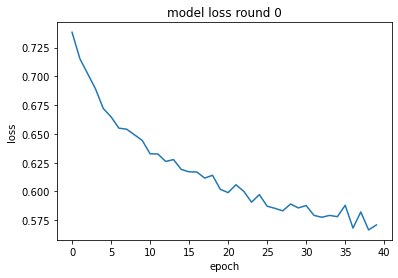

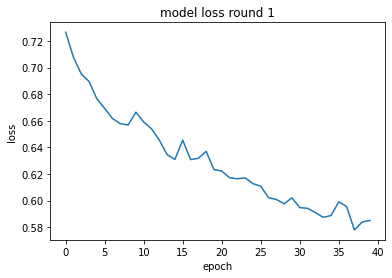

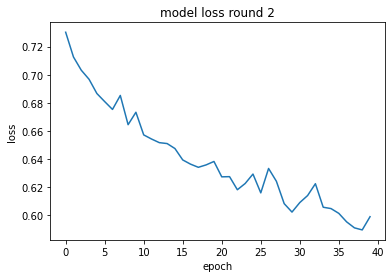

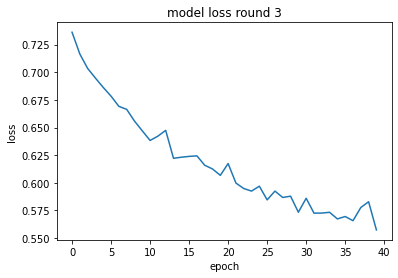

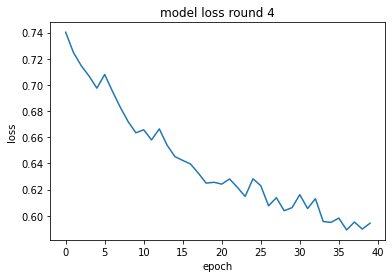

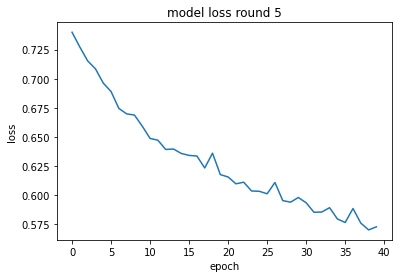

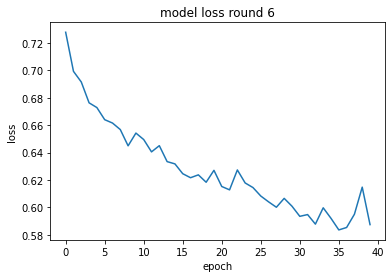

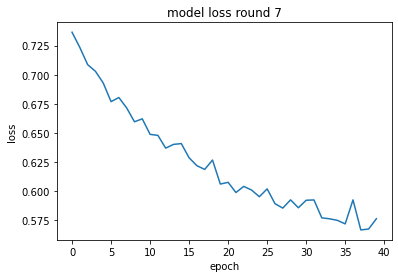

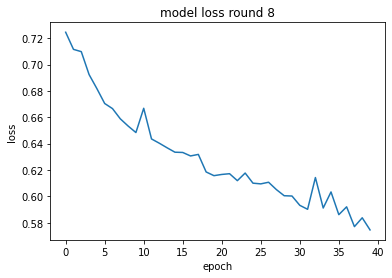

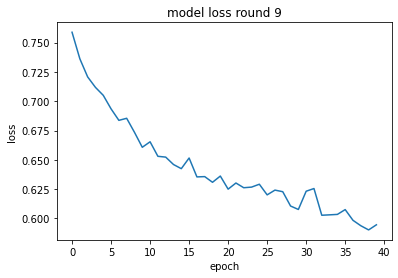

total time for learning:  0:07:16.336572
average of accuracy is:  54.565


In [17]:
from numpy.lib.shape_base import vsplit # used for batch extraction from our dataset matrix
import datetime, time # used for computing time of learning
import matplotlib.pyplot as plt

# pick 8000 data from the test set with their labels
gray_test_img_8000 = (np.vsplit(gray_test_img, np.array([8000, ])))[0] # image
test_label_8000 = (np.vsplit(test_label, np.array([8000, ])))[0] # label

start_time = datetime.datetime.now() # time of start learning

avg_accuracy = 0
for r in range(10):
  # allocate and initialize W matrix and vector b for each layer
  W1, W2, W3 = initialize_weights()
  b1, b2, b3 = initialize_biases()

  # set hyperparameters (learning_rate, number_of_epochs, and batch_size)
  batch_size = 16
  learning_rate = 0.3
  number_of_epochs = 40

  # find the number of batches based on the number of data in the dataset
  X_no_rows = gray_test_img_8000.shape[0]
  batch_no = int(X_no_rows / batch_size)

  # a list to store costs for each epoch to check that learning is doing correctly
  epoch_costs_all = []

  # loop over the number of epochs
  for i in range(number_of_epochs):
    gray_test_img_8000, test_label_8000 = shuffle_dataset(gray_test_img_8000, test_label_8000) # shuffle the train set
    for j in range(batch_no): # loop over the batches in each epoch
      # allocate grad_W matrix and vector grad_b for each layer and initialize to 0
      grad_W3 = np.zeros_like(W3)
      grad_b3 = np.zeros_like(b3)
      grad_W2 = np.zeros_like(W2)
      grad_b2 = np.zeros_like(b2)
      grad_W1 = np.zeros_like(W1)
      grad_b1 = np.zeros_like(b1)

      # extract images of this batch
      batch_X = np.vsplit(gray_test_img_8000, np.array([16*j, 16*(j+1)]))[1]
      batch_Y_star = np.vsplit(test_label_8000, np.array([16*j, 16*(j+1)]))[1]

      # loop over images of this batch
      for k in range(np.shape(batch_X)[0]):
        # extract current image of batch
        image_X = batch_X[k].reshape(1, 1024)
        image_Y_star = batch_Y_star[k].reshape(4, 1)

        # compute the output for this image.
        a1 = sigmoid((np.dot(W1, image_X.T) + b1))
        a2 = sigmoid((np.dot(W2, a1) + b2))
        a3 = sigmoid((np.dot(W3, a2) + b3))

        # compute gradients for each layer
        grad_W3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3))) @ (a2.T)    # d_cost/d_W3
        grad_b3 += (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_b3

        grad_a2 = (W3.T) @ (2 * (a3 - image_Y_star) * (a3 * (1 - a3)))    # d_cost/d_a2
        grad_W2 += (grad_a2 * (a2 * (1 - a2))) @ (a1.T)    # d_cost/d_W2
        grad_b2 += (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_b2
        
        grad_a1 = (W2.T) @ (grad_a2 * (a2 * (1 - a2)))    # d_cost/d_a1
        grad_W1 += (grad_a1 * (a1 * (1 - a1))) @ (image_X) # d_cost/d_W1
        grad_b1 += (grad_a1 * (a1 * (1 - a1)))    # d_cost/d_b1

      # move to local minimum
      W3 -= (learning_rate * (grad_W3/batch_size))
      W2 -= (learning_rate * (grad_W2/batch_size))
      W1 -= (learning_rate * (grad_W1/batch_size))

      b3 -= (learning_rate * (grad_b3/batch_size))
      b2 -= (learning_rate * (grad_b2/batch_size))
      b1 -= (learning_rate * (grad_b1/batch_size))
    
    # compute output for each epoch
    a1 = sigmoid((np.dot(W1, gray_test_img_8000.T) + b1))
    a2 = sigmoid((np.dot(W2, a1) + b2))
    a3 = sigmoid((np.dot(W3, a2) + b3))
    a3 = a3.T
    
    # compute cost of each epoch
    epoch_cost = comput_cost(test_label_8000, a3)
    epoch_costs_all.append(epoch_cost)

  # plot model loss (loss of each epoch)
  title = "model loss round " + str(r)
  plt.title(title)
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.plot(np.array(epoch_costs_all)/X_no_rows)
  plt.show()

  # compute accuracy of model
  a1 = sigmoid((np.dot(W1, gray_test_img_8000.T) + b1))
  a2 = sigmoid((np.dot(W2, a1) + b2))
  a3 = sigmoid((np.dot(W3, a2) + b3))
  a3 = a3.T

  # Y is the predicted matrix of inputs
  Y = np.empty_like(a3)
  j = 0
  for i in np.argmax(a3, axis=1):
    Y_vector = np.zeros((1, len(classes)))
    Y_vector[0, i] = 1
    Y[j] = Y_vector
    j += 1

  # find the number of correct predictions by our neural network
  j = 0 # number of correct predictions
  for i in (test_label_8000 - Y):
    if (i == np.array([0, 0, 0, 0])).all():
      j += 1

  # accuracy of our model (it may be near 55 %)
  accuracy = (j / gray_test_img_8000.shape[0]) * 100
  avg_accuracy += accuracy

end_time = datetime.datetime.now() # time of end learning

# compute learning time
learning_time = end_time - start_time
avg_accuracy /= 10
print("total time for learning: ", learning_time)
print("average of accuracy is: ", avg_accuracy)